In [1]:
import jax.numpy as np
import matplotlib.pyplot as plt

from ode_filters.filters import ekf1_sqr_loop, rts_sqr_smoother_loop
from ode_filters.measurement import ODEInformation
from ode_filters.priors import IWP, taylor_mode_initialization

## Example Problem: Logistic ODE

$$\dot{x}(t) = x(t)(1-x(t)), \quad x(0) = x_0 = 0.01, \quad t\in [0,10]$$


### 1. Define the Initial Value Problem (IVP)


In [2]:
def vf(x, *, t):
    return x * (1 - x)


x0 = np.array([0.01])
tspan = [0, 10]
d = x0.shape[0]

### 2. Select a Prior

e.g. a q-times integrated wiener process:


In [3]:
q = 2
xi = 0.5 * np.eye(d)
prior = IWP(q, d, Xi=xi)
mu_0, Sigma_0_sqr = taylor_mode_initialization(vf, x0, q)

### 4. Define the measuement model

e.g. the naive ODE information operator


In [4]:
measure = ODEInformation(vf, prior.E0, prior.E1)

### 5. Apply ODE filtering and smoothing loop

e.g. EKF1 filtering and RTS smoothing.


In [5]:
N = 21

(
    m_seq,
    P_seq_sqr,
    m_pred_seq,
    P_pred_seq_sqr,
    G_back_seq,
    d_back_seq,
    P_back_seq_sqr,
    mz_seq,
    Pz_seq_sqr,
) = ekf1_sqr_loop(mu_0, Sigma_0_sqr, prior, measure, tspan, N)


In [6]:
m_smoothed, P_smoothed_sqr = rts_sqr_smoother_loop(
    m_seq[-1], P_seq_sqr[-1], G_back_seq, d_back_seq, P_back_seq_sqr, N
)

### 6. Visualise the results


In [7]:
m_seq = np.array(m_seq)
P_seq_sqr = np.array(P_seq_sqr)


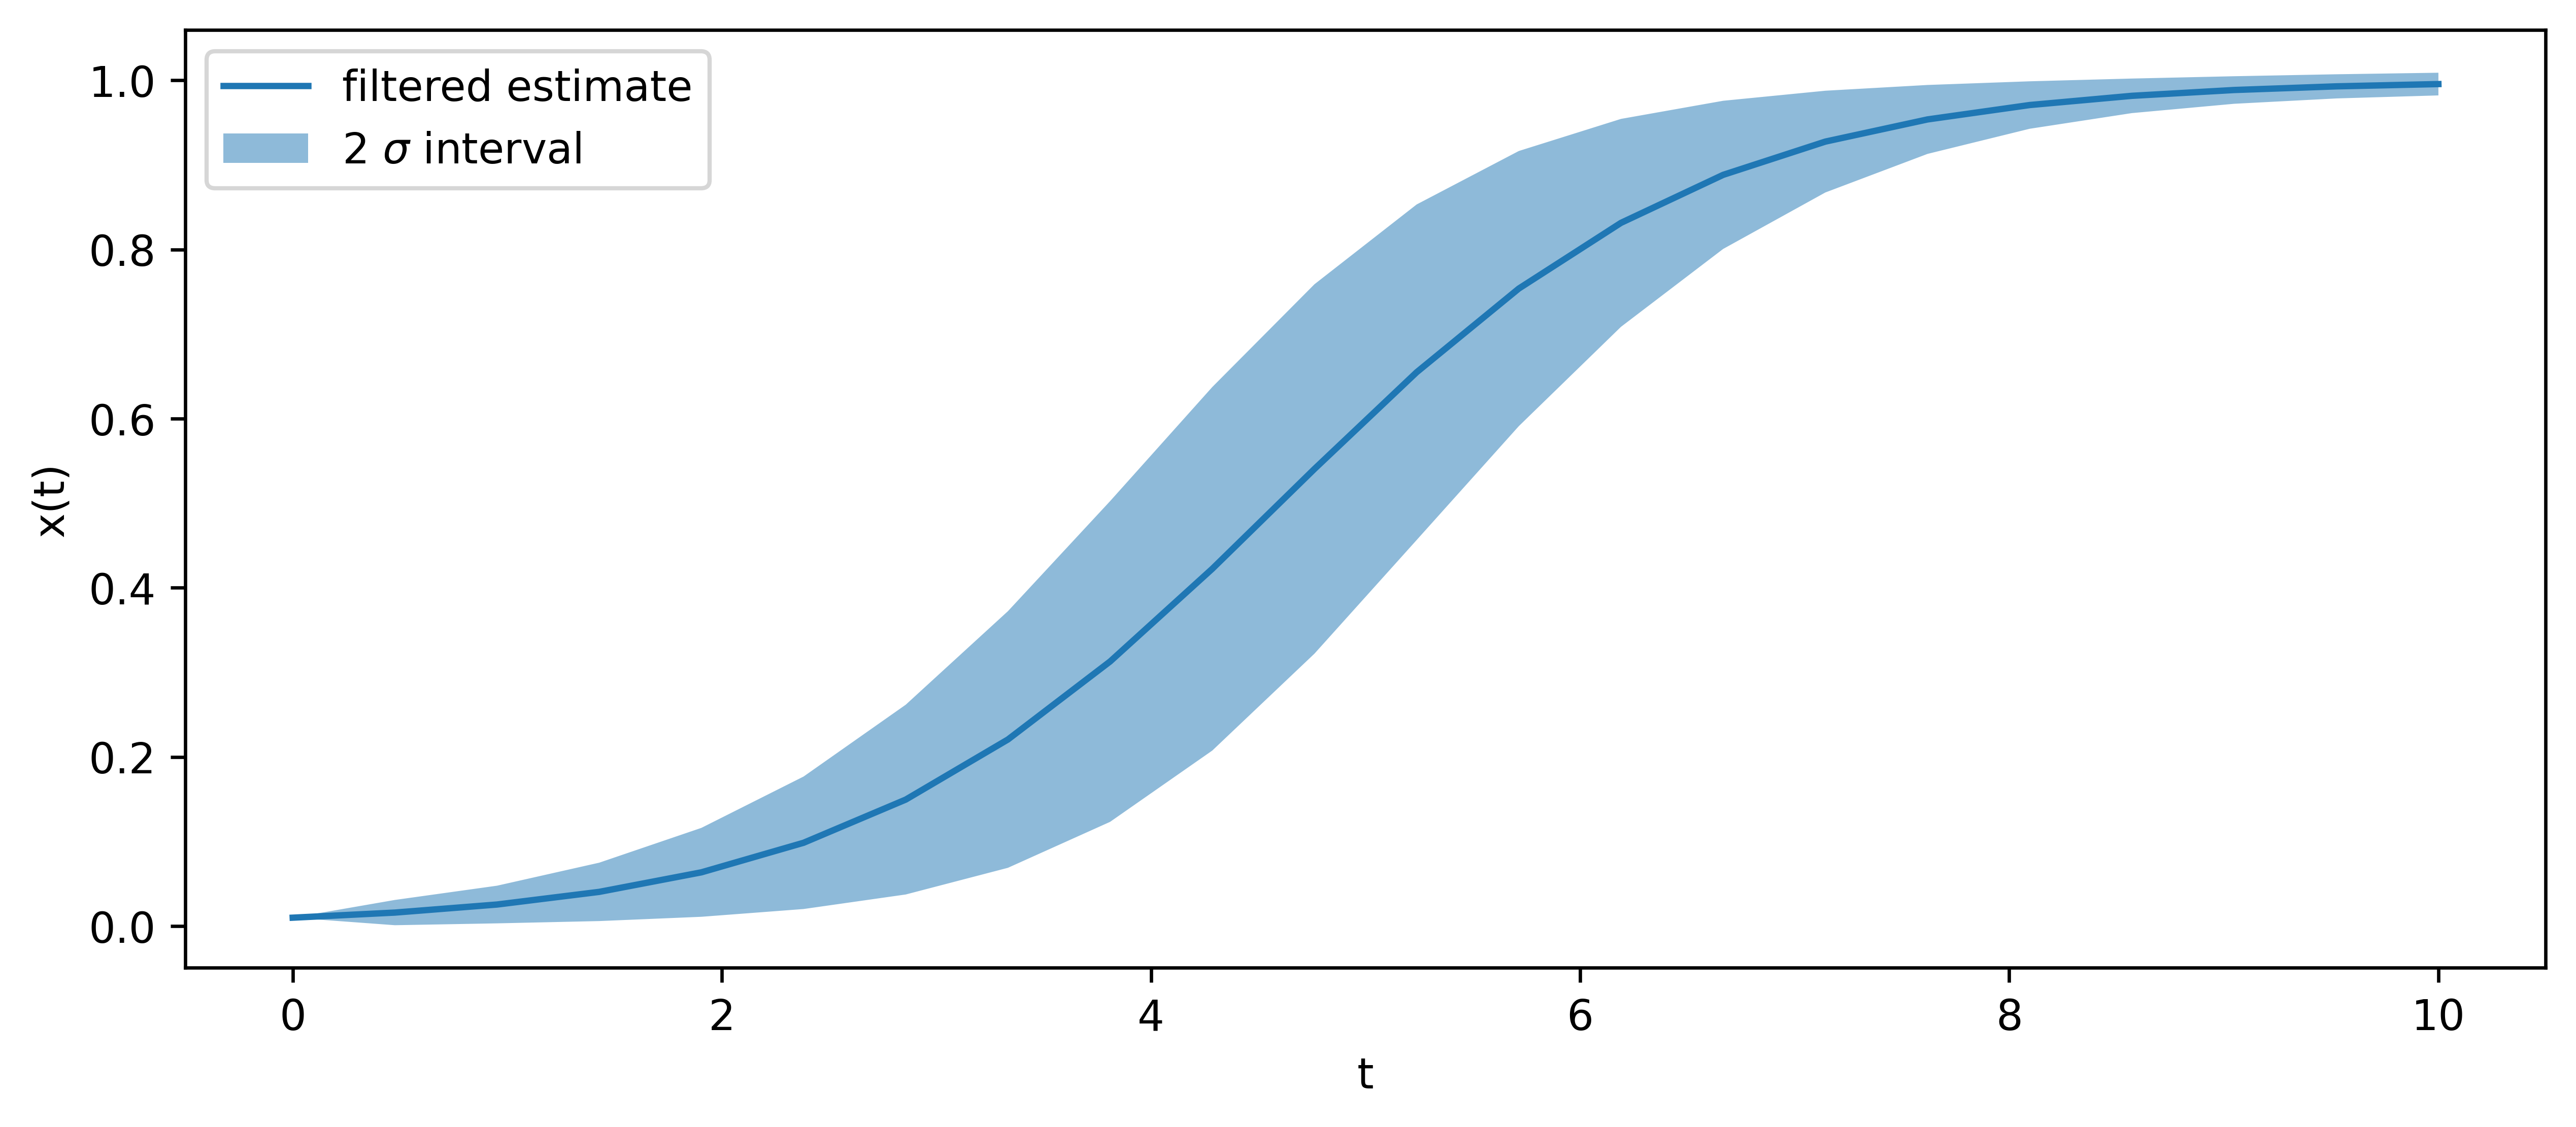

In [8]:
ts = np.linspace(tspan[0], tspan[1], N + 1)
plt.figure(figsize=(10, 4), dpi=600)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.plot(ts, m_seq[:, 0], label="filtered estimate")
P_seq = np.matmul(np.transpose(P_seq_sqr, (0, 2, 1)), P_seq_sqr)
margin = 2 * np.sqrt(P_seq[:, 0, 0])
plt.fill_between(
    ts,
    m_seq[:, 0] - margin,
    m_seq[:, 0] + margin,
    alpha=0.5,
    label=r"2 $\sigma$ interval",
)
plt.legend()
plt.show()